## Building a classifier for Loans




In [1]:
# Importing the modules: 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sqlite3 as sql
import pickle


from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split



In [2]:

os.chdir('/home/zeski/Documents/PythonLessons/MachineLearning/Projects/LendingClub/lending-club-loan-data')

In [3]:
## Connecting to the sqlite database
conn = sql.connect('database.sqlite')
cur = conn.cursor()

In [4]:
# Checking the tables of the sqlite database

cur.execute("""
SELECT name FROM sqlite_master WHERE type = 'table'
""")
print(cur.fetchall())


[('loan',)]


# Wrangling and Preprocessing the Data:

In [5]:

columns = cur.execute("""
PRAGMA TABLE_INFO('loan'); 

""").fetchall()

column_names = []
for i in columns: 
    column_names.append(i[1])
    
dictionary_data= {}

for i, k in enumerate(columns): 
    #print('Column number: {},\nColumn name: {}'.format(i,k[1]))
    #print('============================')
    dictionary_data[i] = []

data = cur.execute("""
SELECT * from loan LIMIT 100000
""").fetchall()

for i in data:
    for p,k in enumerate(i):
        dictionary_data[p].append(k)

df = pd.DataFrame(dictionary_data)
df.columns = column_names

len(df)

100000

In [6]:
## Because of minute positive Defaults, I am selecting 1500 of the data and appending to the end of the dataframe

positive_values = """
SELECT * FROM loan  WHERE loan_status = "Default" LIMIT 1500

"""
positive_targets = cur.execute(positive_values).fetchall()

dictionary_data= {}

for i, k in enumerate(columns): 
    #print('Column number: {},\nColumn name: {}'.format(i,k[1]))
    #print('============================')
    dictionary_data[i] = []

for i in positive_targets:
    for p,k in enumerate(i):
        dictionary_data[p].append(k)
target_df = pd.DataFrame(dictionary_data)
target_df.columns = column_names

df = df.append(target_df)
len(df)

101219

In [7]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)', None,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [8]:
df['Defaulted'] = np.where(df.loan_status.isin(['Default']), 1, 0)
df['Defaulted'].unique()
df.drop(['loan_status'], axis = 1, inplace = True)
#The average amount of times a loan was defaulted per 100000 users
df['Defaulted'].mean()

0.012922475029391716

## Exploring Null Values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101219 entries, 0 to 1218
Data columns (total 75 columns):
index                          101219 non-null int64
id                             101219 non-null object
member_id                      101218 non-null float64
loan_amnt                      101218 non-null float64
funded_amnt                    101218 non-null float64
funded_amnt_inv                101218 non-null float64
term                           101218 non-null object
int_rate                       101218 non-null object
installment                    101218 non-null float64
grade                          101218 non-null object
sub_grade                      101218 non-null object
emp_title                      94791 non-null object
emp_length                     101218 non-null object
home_ownership                 101218 non-null object
annual_inc                     101214 non-null float64
verification_status            101218 non-null object
issue_d                

In [10]:
print("Total Postitive Target data: {}".format(df.Defaulted.sum()))
before = df.Defaulted.sum()
percent_data_missing=(df.isnull().sum()/ len(df)) * 100
missing_data_remaining = []
for i in percent_data_missing.index:
    if percent_data_missing[i] > 50.0:
        ## Dropping entire column if the amount of missing data exceeds 50%
        df.drop([i], axis = 1, inplace = True)
    elif percent_data_missing[i] < 1: 
        ## If the amount of missing data is less than 1%, dropping the rows where data is missing
        df[i].dropna(inplace= True)
    else: 
        ## For any data that still has missing values, I will inspect and deal with by hand.
        missing_data_remaining.append(i)
after = df.Defaulted.sum()
if before == after: 
    print("No target data lost.")

print("Data still missing in columns {}".format(missing_data_remaining))

Total Postitive Target data: 1308
No target data lost.
Data still missing in columns ['emp_title', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']


In [11]:
indexes = {}
for i in missing_data_remaining:
    null_data = df[df[i].isnull()] ## Looking for the data that has missing values in the column. 
    print("Column {} ------ Missing Data rows containing target: {}".format(i,null_data.Defaulted.sum()))
    null_vals = null_data[null_data['Defaulted'] == 1] ## Looking at the index  values of the null values per  column where the target is present as positive. Given that there is a small representation of positive target values, must be cautious to delete the data.
    indexes[i] = null_vals.index  ## creating a dictionary to look up those index values per column.
print("\nIndex Locations for missing rows of data per column containing a positive target variable")
indexes

Column emp_title ------ Missing Data rows containing target: 86
Column tot_coll_amt ------ Missing Data rows containing target: 27
Column tot_cur_bal ------ Missing Data rows containing target: 27
Column total_rev_hi_lim ------ Missing Data rows containing target: 27

Index Locations for missing rows of data per column containing a positive target variable


{'emp_title': Int64Index([17159, 53305, 57835, 65198, 78324, 89876, 96458,     5,    26,
                33,    44,    60,    77,    88,   116,   117,   126,   130,
               156,   170,   173,   190,   199,   224,   235,   244,   257,
               288,   329,   357,   358,   362,   364,   390,   397,   436,
               502,   505,   511,   522,   528,   534,   545,   551,   577,
               589,   629,   644,   646,   689,   693,   712,   729,   740,
               760,   775,   783,   795,   796,   801,   830,   831,   834,
               845,   847,   879,   888,   957,   960,   962,  1008,  1026,
              1039,  1090,  1098,  1100,  1110,  1118,  1119,  1144,  1176,
              1180,  1190,  1191,  1197,  1211],
            dtype='int64'),
 'tot_coll_amt': Int64Index([  318,  7620, 11759, 13439, 13856, 17159, 18912, 21228, 23773,
                 0,     1,     2,     3,     4,     5,     6,     7,     8,
               210,   211,   212,   213,   214,   215,   2

In [12]:
## Going through the indexes to identify and delete the data. 

last = []
for i, k in indexes.items():
    delete_indexes = []
    for p in k: 
        if p not in last:
            last.append(p)
            #delete_indexes.append(p)
        else: 
            pass
    

df_null_values_target = df.iloc[last, :]
df.dropna(inplace = True)

#df = df.append(df_null_values_target)
final = df.Defaulted.sum()
df.reset_index(inplace = True, drop= True)
if final == before: 
    print("No Positive Target Data Lost")
else: 
    print("{} Rows of  Positive Target Data Lost".format(before - final))
    

120 Rows of  Positive Target Data Lost


## Handle the missing data.

df_null_values_target

## Inspecting the Data types of the columns. 

In [13]:
#### Rounding up the object variables: 

object_variables  = []
integer_variables = []

for i in df.columns: 
    if df[i].dtype == "object":
        object_variables.append(i)
    elif i == "Defaulted": 
        Y = df[i].values.reshape(-1,)
    elif df[i].dtype == 'int64': 
        integer_variables.append(i)
    elif df[i].dtype == 'float64': 
        integer_variables.append(i)

In [14]:
## Exploring the Object variables.
#df1 = df.copy()
for i in object_variables: 
    print(i)
    print(df[i].head())
    print("-"*65)

id
0    10149342
1    10159584
2    10159498
3    10139658
4    10159548
Name: id, dtype: object
-----------------------------------------------------------------
term
0     36 months
1     36 months
2     36 months
3     36 months
4     36 months
Name: term, dtype: object
-----------------------------------------------------------------
int_rate
0     10.99%
1     13.98%
2      6.62%
3     13.53%
4      8.90%
Name: int_rate, dtype: object
-----------------------------------------------------------------
grade
0    B
1    C
2    A
3    B
4    A
Name: grade, dtype: object
-----------------------------------------------------------------
sub_grade
0    B2
1    C1
2    A2
3    B5
4    A5
Name: sub_grade, dtype: object
-----------------------------------------------------------------
emp_title
0    Team Leadern Customer Ops & Systems
1                      Medical Assistant
2           MANAGER INFORMATION DELIVERY
3                        On road manager
4          aircraft maintenance eng

In [15]:
## Handling errors in object variables. 
for i, k in enumerate(object_variables): 
    if (k == "int_rate") | (k == "revol_util"):
        df[k] = df[k].str.replace("%", "").astype("float64")
    elif k  == "term": 
        df[k] = df[k].str.replace("months", "").astype("int64")
    elif k == "emp_length": 
        drop_indexes = []
        empl_df = pd.DataFrame(df[k])
        for ind, year in empl_df.iterrows():
            #print(year[0])
            if year[0] == 'n/a': 
                drop_indexes.append(ind)
            else:
                pass
        df.drop(drop_indexes,axis = 0, inplace = True)
        df[k] = df[k].str.replace("years", "")
        df[k] = df[k].str.replace("year", "")
        df[k] = df[k].str.replace("<", "")
        df[k] = df[k].str.replace("+", "").astype("int")
    elif (k == "earliest_cr_line") | (k == "last_pymnt_d") | (k == "last_credit_pull_d") | (k == "issue_d"): 
        df[k] = pd.to_datetime(df[k], errors = 'coerce')
        #df_date[k + '_date'] = df[k].dt.date
        #df[k] = df[k].dt.seconds
    elif k == "id":
        df[k] = df[k].astype("int64")
object_drops = ["url", "zip_code", "application_type", 'index', 'pymnt_plan']
#df.drop(object_drops, axis = 1, inplace = True)


for i in object_variables:
    #print(df[i].dtype)
    if i in object_drops: 
        object_variables.remove(i)
        print(i)
    elif df[i].dtype != "object":
        object_variables.remove(i)
    elif df[i].dtype == "datetime64[ns]":
        object_variables.remove(i)
    else: 
        pass

url
zip_code
application_type


for i in object_variables: 
    print(i)
    print(df[i].unique())
    print("\n")

df = df1.copy()

In [16]:

df[object_variables].head()

,term,grade,sub_grade,emp_title,home_ownership,verification_status,pymnt_plan,purpose,title,addr_state,revol_util,initial_list_status,last_credit_pull_d
0,36,B,B2,Team Leadern Customer Ops & Systems,OWN,Verified,n,debt_consolidation,Debt Consolidation,MI,61.2,w,2015-12-01
1,36,C,C1,Medical Assistant,RENT,Not Verified,n,debt_consolidation,Debt Consilation,CA,52.8,f,2016-01-01
2,36,A,A2,MANAGER INFORMATION DELIVERY,MORTGAGE,Not Verified,n,debt_consolidation,UNIVERSAL CARD,CT,21.6,w,2016-01-01
3,36,B,B5,On road manager,RENT,Source Verified,n,debt_consolidation,Debt consolidation,NM,68.8,w,2016-01-01
4,36,A,A5,aircraft maintenance engineer,MORTGAGE,Not Verified,n,debt_consolidation,Pay off,FL,74.2,w,2016-01-01


In [17]:
dummy_variables = []
for i in object_variables:
    #print(len(df[i].unique()))
    if (i in ['emp_title', 'issue_d', 'title', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d', 'pymnt_plan']): ## Because I am having issues removing the last datetime variable from the list, I will capture it using this for loop. Segregating into variables to be dropped and variables to be encoded.
        object_variables.remove(i)
        if (i in ['emp_title', 'title','pymnt_plan']):
            object_drops.append(i)
            
            

dummy_variables = object_variables

        
## These variables will be dummy encoded        
os.chdir("EncodedVariables_pickles/")


dummy_variables  

with open("dummy_variable_list.pickle", 'wb') as f:
    pickle.dump(dummy_variables, f)
    


### Making the pickles directories

os.mkdir("EncodedVariables_pickles")<br>
os.mkdir("ScaledVariables_pickles")

In [18]:
os.listdir()

['title_label_encoder.pickle',
 'last_credit_pull_d_label_encoder.pickle',
 'loan_status_label_encoder.pickle',
 'purpose_label_encoder.pickle',
 'addr_state_label_encoder.pickle',
 'grade_label_encoder.pickle',
 'home_ownership_label_encoder.pickle',
 'revol_util_label_encoder.pickle',
 'term_label_encoder.pickle',
 'verification_status_label_encoder.pickle',
 'sub_grade_label_encoder.pickle',
 'dummy_variable_list.pickle',
 'initial_list_status_label_encoder.pickle',
 'pymnt_plan_label_encoder.pickle',
 'emp_title_label_encoder.pickle']

In [19]:
## Preprocess and scale the data


## Encoding the dummy_variables
for i in dummy_variables: 
    label_encoder = LabelEncoder()
    
    df[i] = label_encoder.fit_transform(df[i])
    print(df[i].unique())
    with open("{}_label_encoder.pickle".format(i), 'wb') as f: 
        pickle.dump(label_encoder, f)
print(os.listdir())
os.chdir("..")

[0 1]
[1 2 0 3 4 5 6]
[ 6 10  1  9  4  7  8 14  5  2 19 12 23 11 18 20 13 17 21  0  3 16 22 24
 15 25 32 30 26 28 29 34 33 27 31]
[1 2 0]
[2 0 1]
[ 2  8  1  3 10  5  4  7  6  0 11  9 12]
[20  4  6 29  9  5 25 18 40 31 14 35 32 10 41  3 28 37 16  8 13 45 22 21
 19 44 42 47 39 27 30 15 36  1 34 46 17 43 33  2 11 24  0 38  7 26 12 23]
[ 612  528  216 ... 1049 1021 1040]
[1 0]
['title_label_encoder.pickle', 'last_credit_pull_d_label_encoder.pickle', 'loan_status_label_encoder.pickle', 'purpose_label_encoder.pickle', 'addr_state_label_encoder.pickle', 'grade_label_encoder.pickle', 'home_ownership_label_encoder.pickle', 'revol_util_label_encoder.pickle', 'term_label_encoder.pickle', 'verification_status_label_encoder.pickle', 'sub_grade_label_encoder.pickle', 'dummy_variable_list.pickle', 'initial_list_status_label_encoder.pickle', 'pymnt_plan_label_encoder.pickle', 'emp_title_label_encoder.pickle']


In [20]:
df.dtypes

index                                  int64
id                                     int64
member_id                            float64
loan_amnt                            float64
funded_amnt                          float64
funded_amnt_inv                      float64
term                                   int64
int_rate                             float64
installment                          float64
grade                                  int64
sub_grade                              int64
emp_title                             object
emp_length                             int64
home_ownership                         int64
annual_inc                           float64
verification_status                    int64
issue_d                       datetime64[ns]
pymnt_plan                            object
url                                   object
purpose                                int64
title                                 object
zip_code                              object
addr_state

In [21]:
datetime_variables = ['last_credit_pull_d', 'last_pymnt_d', 'issue_d', 'earliest_cr_line']

In [22]:
import datetime
def ordinal_transform(x): 
    x = datetime.date.toordinal(x)
    return x
for i in datetime_variables: 
    df[i] = df[i].apply(ordinal_transform)
    
    


In [23]:
df.drop(object_drops, axis = 1, inplace = True)

In [24]:
object_drops

['url',
 'zip_code',
 'application_type',
 'index',
 'pymnt_plan',
 'emp_title',
 'pymnt_plan',
 'title']

In [25]:

df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Defaulted
0,10149342,12000897.0,27050.0,27050.0,27050.0,0,10.99,885.46,1,6,...,735964,885.46,735933,0.0,1.0,0.0,0.0,114834.0,59900.0,0
1,10159584,12011200.0,9750.0,9750.0,9750.0,0,13.98,333.14,2,10,...,735964,333.14,735964,0.0,1.0,0.0,0.0,14123.0,15100.0,0
2,10159498,1319523.0,12000.0,12000.0,12000.0,0,6.62,368.45,0,1,...,735964,368.45,735964,0.0,1.0,0.0,0.0,267646.0,61100.0,0
3,10139658,11991209.0,12000.0,12000.0,12000.0,0,13.53,407.40,1,9,...,735842,119.17,735964,0.0,1.0,0.0,15386.0,13605.0,8100.0,0
4,10159548,12011167.0,15000.0,15000.0,15000.0,0,8.90,476.30,0,4,...,735964,476.30,735964,0.0,1.0,0.0,1514.0,272492.0,15400.0,0


## Looking for rare values. 

This will effect how I produce my dummy variables. 

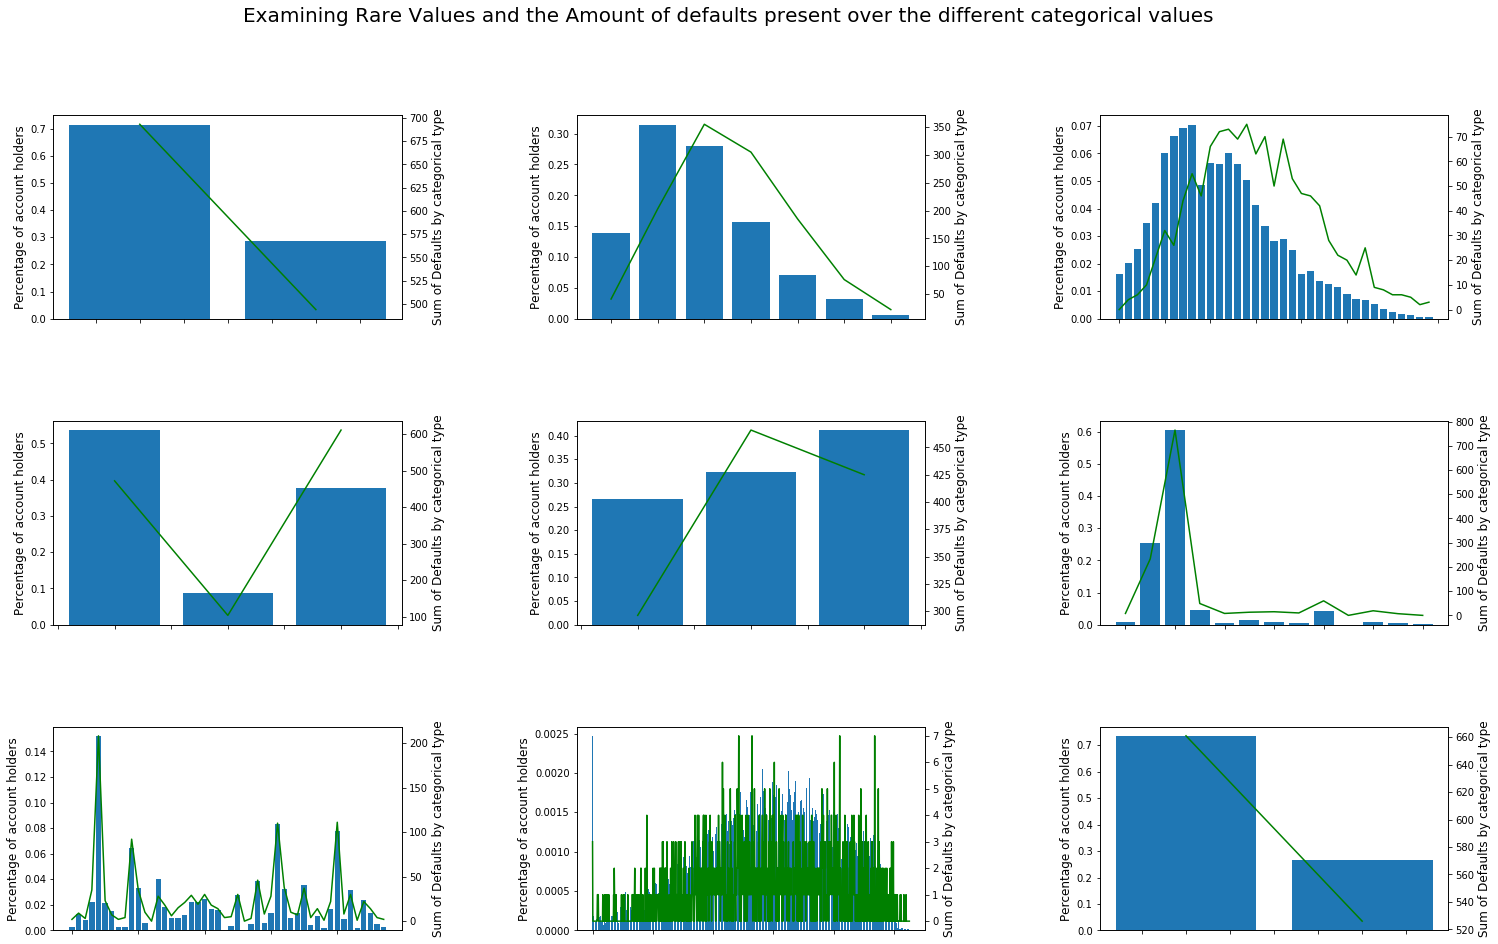

In [26]:


Total_Positions = len(object_variables)

Total_Columns = Total_Positions // 3

Rows = Total_Positions // Total_Columns
Rows += Total_Positions % Total_Columns


Position = range(1, Total_Positions + 1)


fig = plt.figure(figsize = (25, 15))

fig.suptitle("Examining Rare Values and the Amount of defaults present over the different categorical values", fontsize = 20)


for i, k in enumerate(object_variables): 
    counts = pd.Series(df[k].value_counts() / len(df) )
    effect_df = pd.DataFrame(df.groupby(k)['Defaulted'].sum())
    ax = fig.add_subplot(Rows, Total_Columns, Position[i])
    ax2 = ax.twinx()
    ax.set_xticklabels([])
    counts = counts.sort_values(ascending = False)
    ax.bar(counts.index, counts.values)
    ax2.plot(effect_df.index, effect_df['Defaulted'],c = 'green')
    plt.xlabel(k)
    ax.set_ylabel("Percentage of account holders", fontsize = 12)
    ax2.set_ylabel("Sum of Defaults by categorical type", fontsize = 12)
    


plt.subplots_adjust(hspace = 0.5, wspace = 0.5)


## Looking at the Distributions of the variables in the dataset: 




In [27]:
# skimming down on the data that has been dropped from the dataframe
numerical_data =list(set(df.columns).intersection(integer_variables))

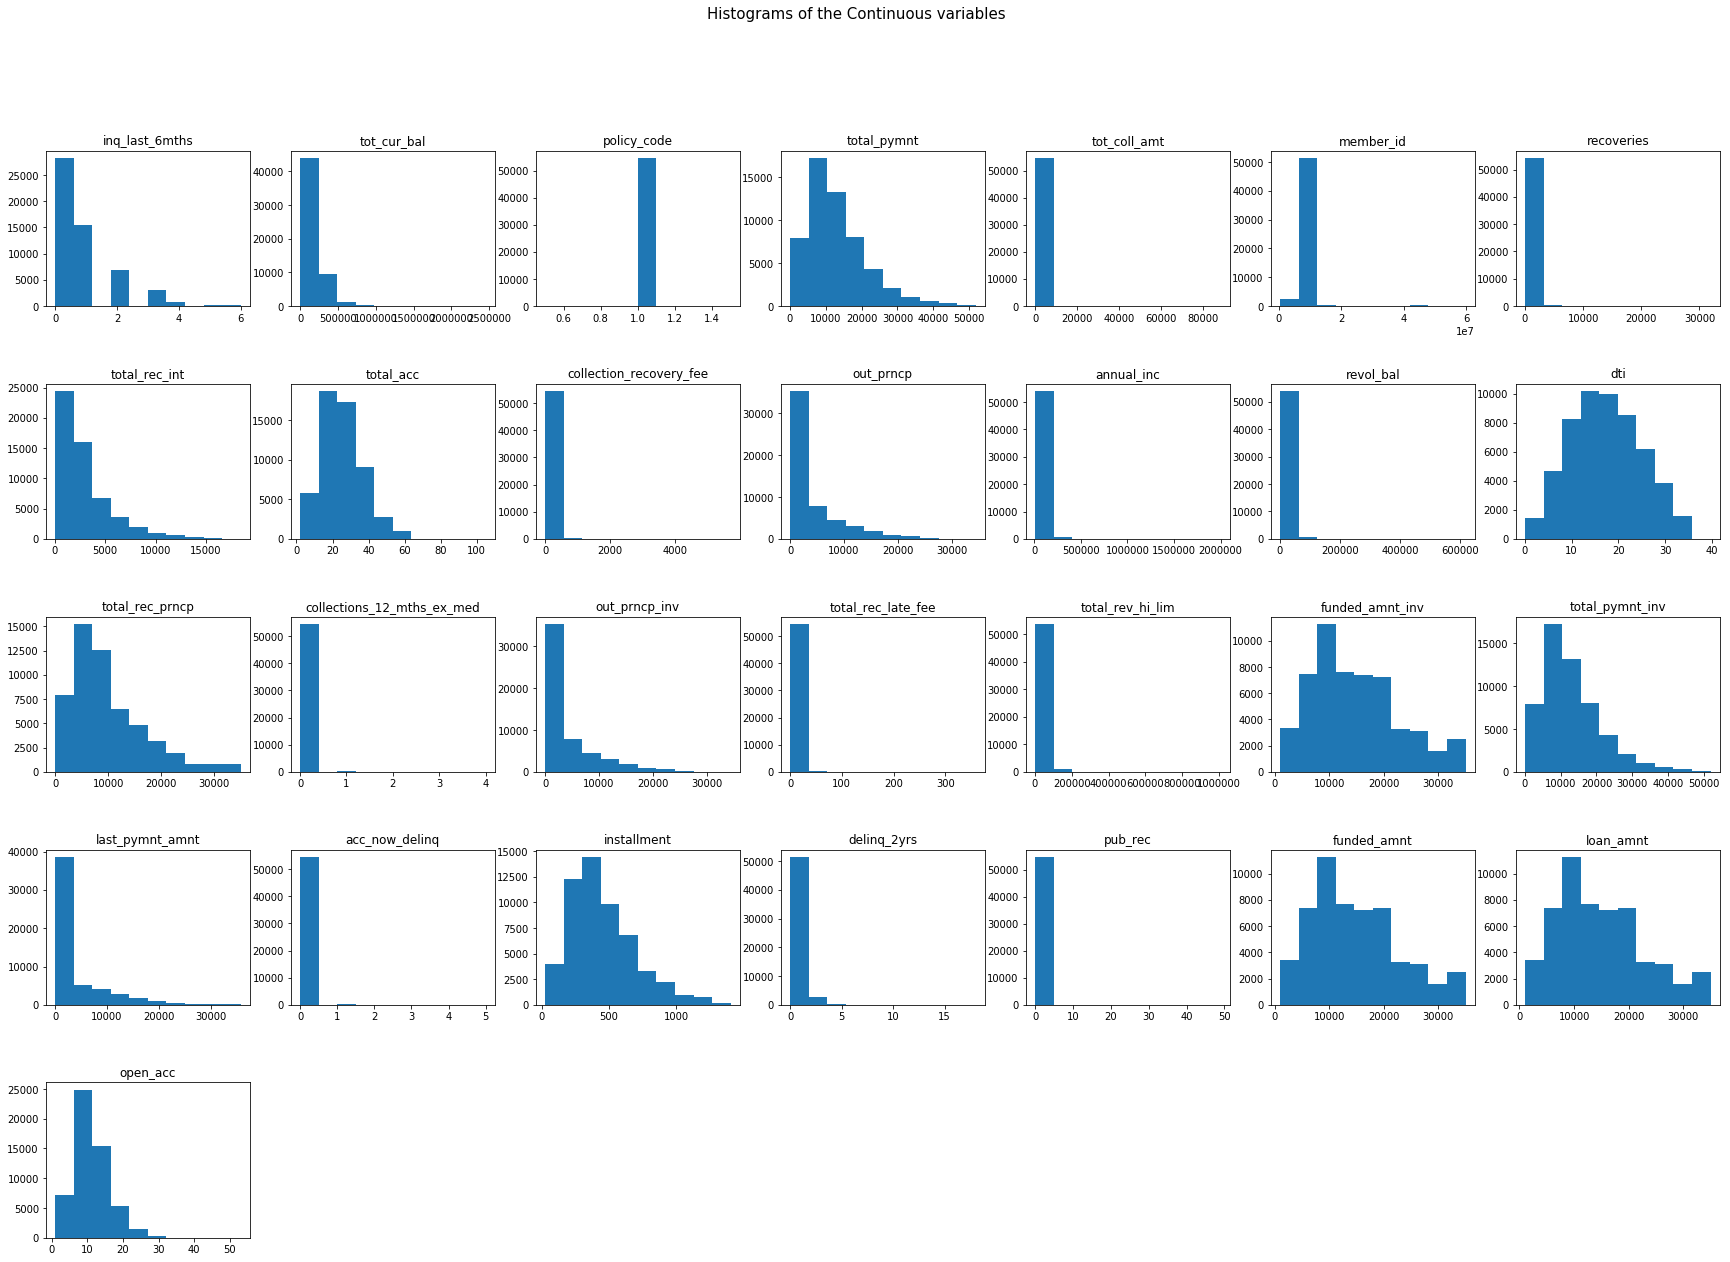

In [28]:
Total_Positions = len(numerical_data)

Total_Columns = Total_Positions // 4  

Rows = Total_Positions // Total_Columns
Rows += Total_Positions % Total_Columns

Position = range(1, Total_Positions + 1)

#plt.rcParams['figure.constrained_layout.use'] = True

fig = plt.figure(figsize=(30, 20))
fig.suptitle("Histograms of the Continuous variables", fontsize = 15)


for i, k in enumerate(numerical_data): 
    ax = fig.add_subplot(Rows, Total_Columns, Position[i])
    ax.hist(df[k])
    ax.set_title("{}".format(k))

plt.subplots_adjust(hspace = 0.5)


## Looking for Outliers in the continuous values: 

Because of a lot of non normality of the continuous variables, I will be using the IQR to identify the outliers present in the data. Also based off of potential outliers in the dataset, the non normaility may be caused by presence of these outliers. This is a tricky issue because, given that fraudulent activity is rare, these outliers may be the telling cases of the fraudulent activity. It may hurt the model to actually remove the outliers. 

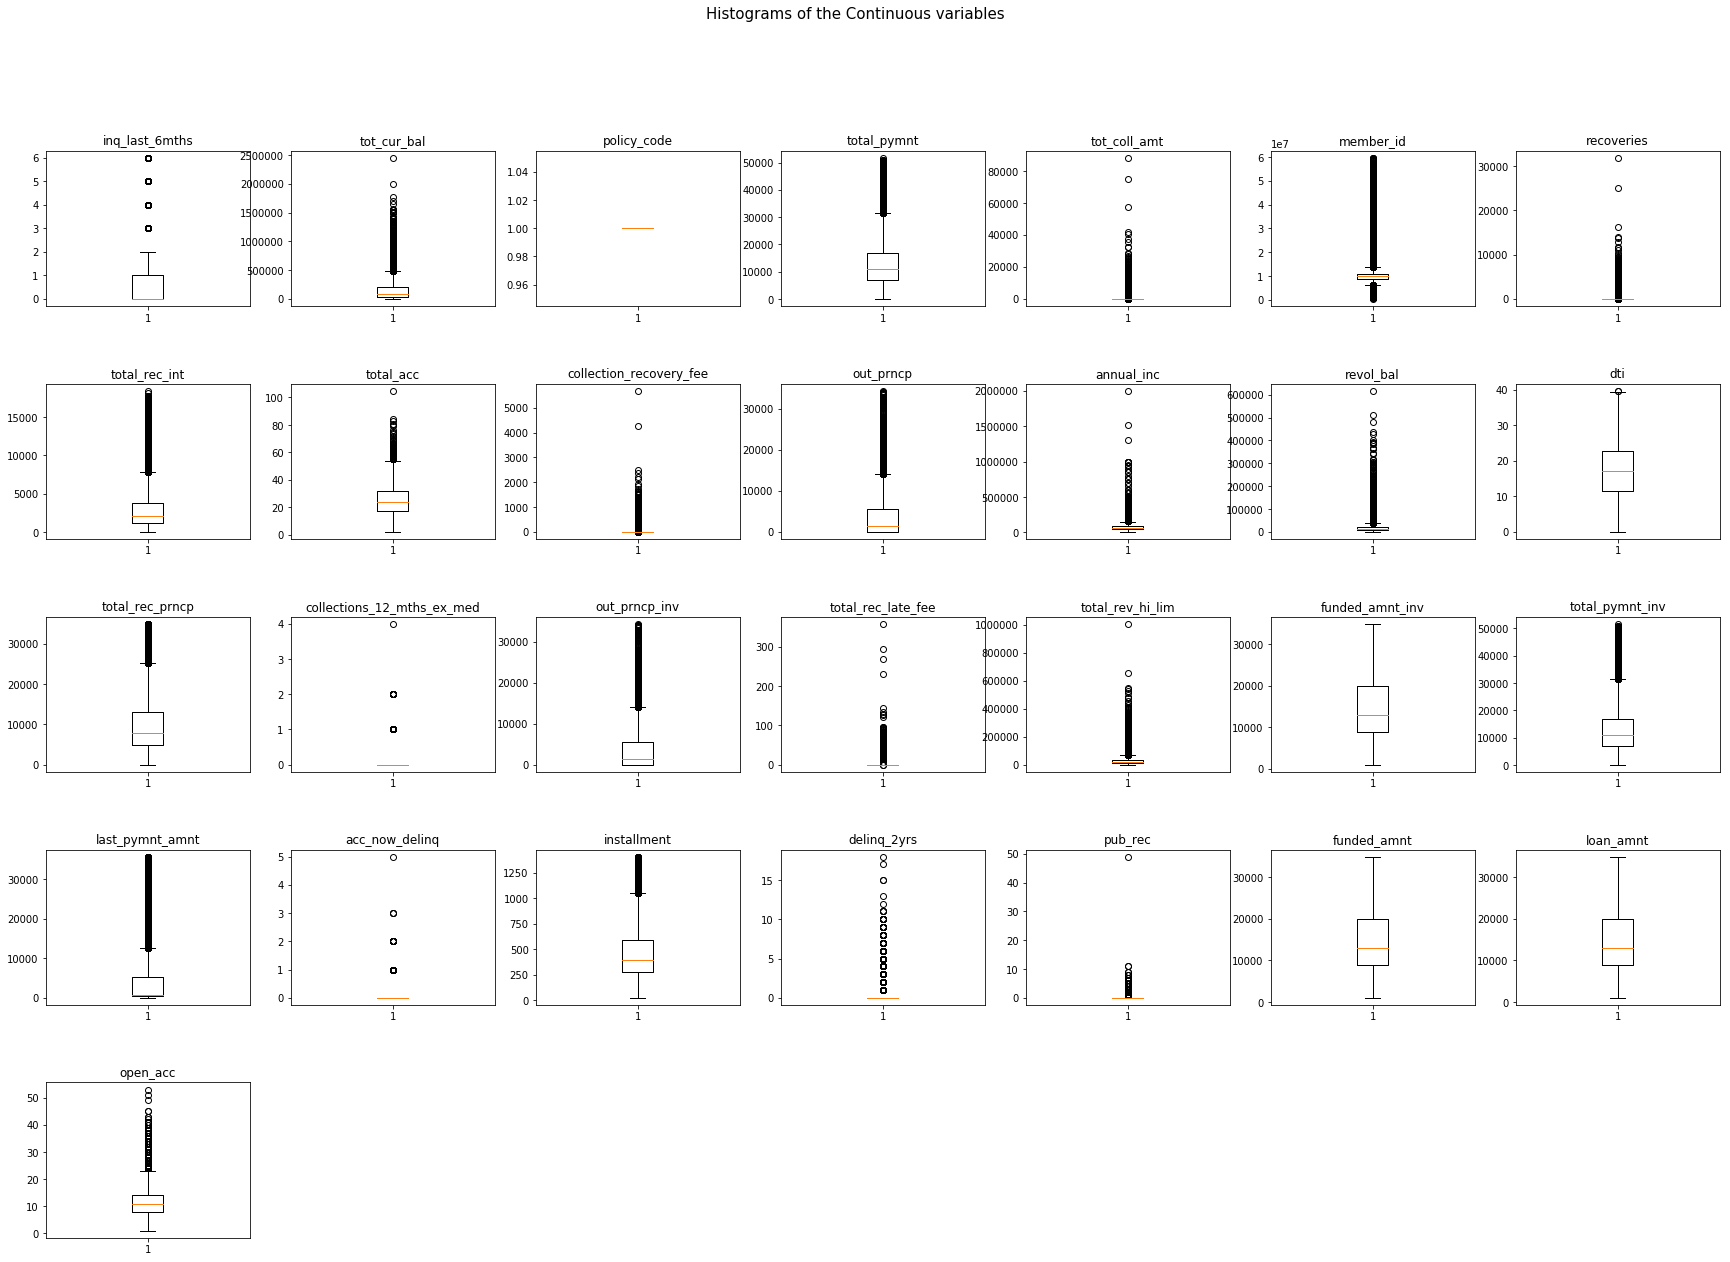

In [29]:
Total_Positions = len(numerical_data)

Total_Columns = Total_Positions // 4  

Rows = Total_Positions // Total_Columns
Rows += Total_Positions % Total_Columns

Position = range(1, Total_Positions + 1)

#plt.rcParams['figure.constrained_layout.use'] = True

fig = plt.figure(figsize=(30, 20))
fig.suptitle("Histograms of the Continuous variables", fontsize = 15)


for i, k in enumerate(numerical_data): 
    ax = fig.add_subplot(Rows, Total_Columns, Position[i])
    ax.boxplot(df[k])
    ax.set_title("{}".format(k))

plt.subplots_adjust(hspace = 0.5)


COLUMN: inq_last_6mths  ---  percentage of outliers   =  8%
COLUMN: tot_cur_bal  ---  percentage of outliers   =  3%
COLUMN: policy_code  ---  percentage of outliers   =  0%
COLUMN: total_pymnt  ---  percentage of outliers   =  3%
COLUMN: tot_coll_amt  ---  percentage of outliers   =  10%
COLUMN: member_id  ---  percentage of outliers   =  6%
COLUMN: recoveries  ---  percentage of outliers   =  5%
COLUMN: total_rec_int  ---  percentage of outliers   =  6%
COLUMN: total_acc  ---  percentage of outliers   =  2%
COLUMN: collection_recovery_fee  ---  percentage of outliers   =  5%
COLUMN: out_prncp  ---  percentage of outliers   =  7%
COLUMN: annual_inc  ---  percentage of outliers   =  4%
COLUMN: revol_bal  ---  percentage of outliers   =  4%
COLUMN: dti  ---  percentage of outliers   =  0%
COLUMN: total_rec_prncp  ---  percentage of outliers   =  4%
COLUMN: collections_12_mths_ex_med  ---  percentage of outliers   =  1%
COLUMN: out_prncp_inv  ---  percentage of outliers   =  7%
COLUMN: t

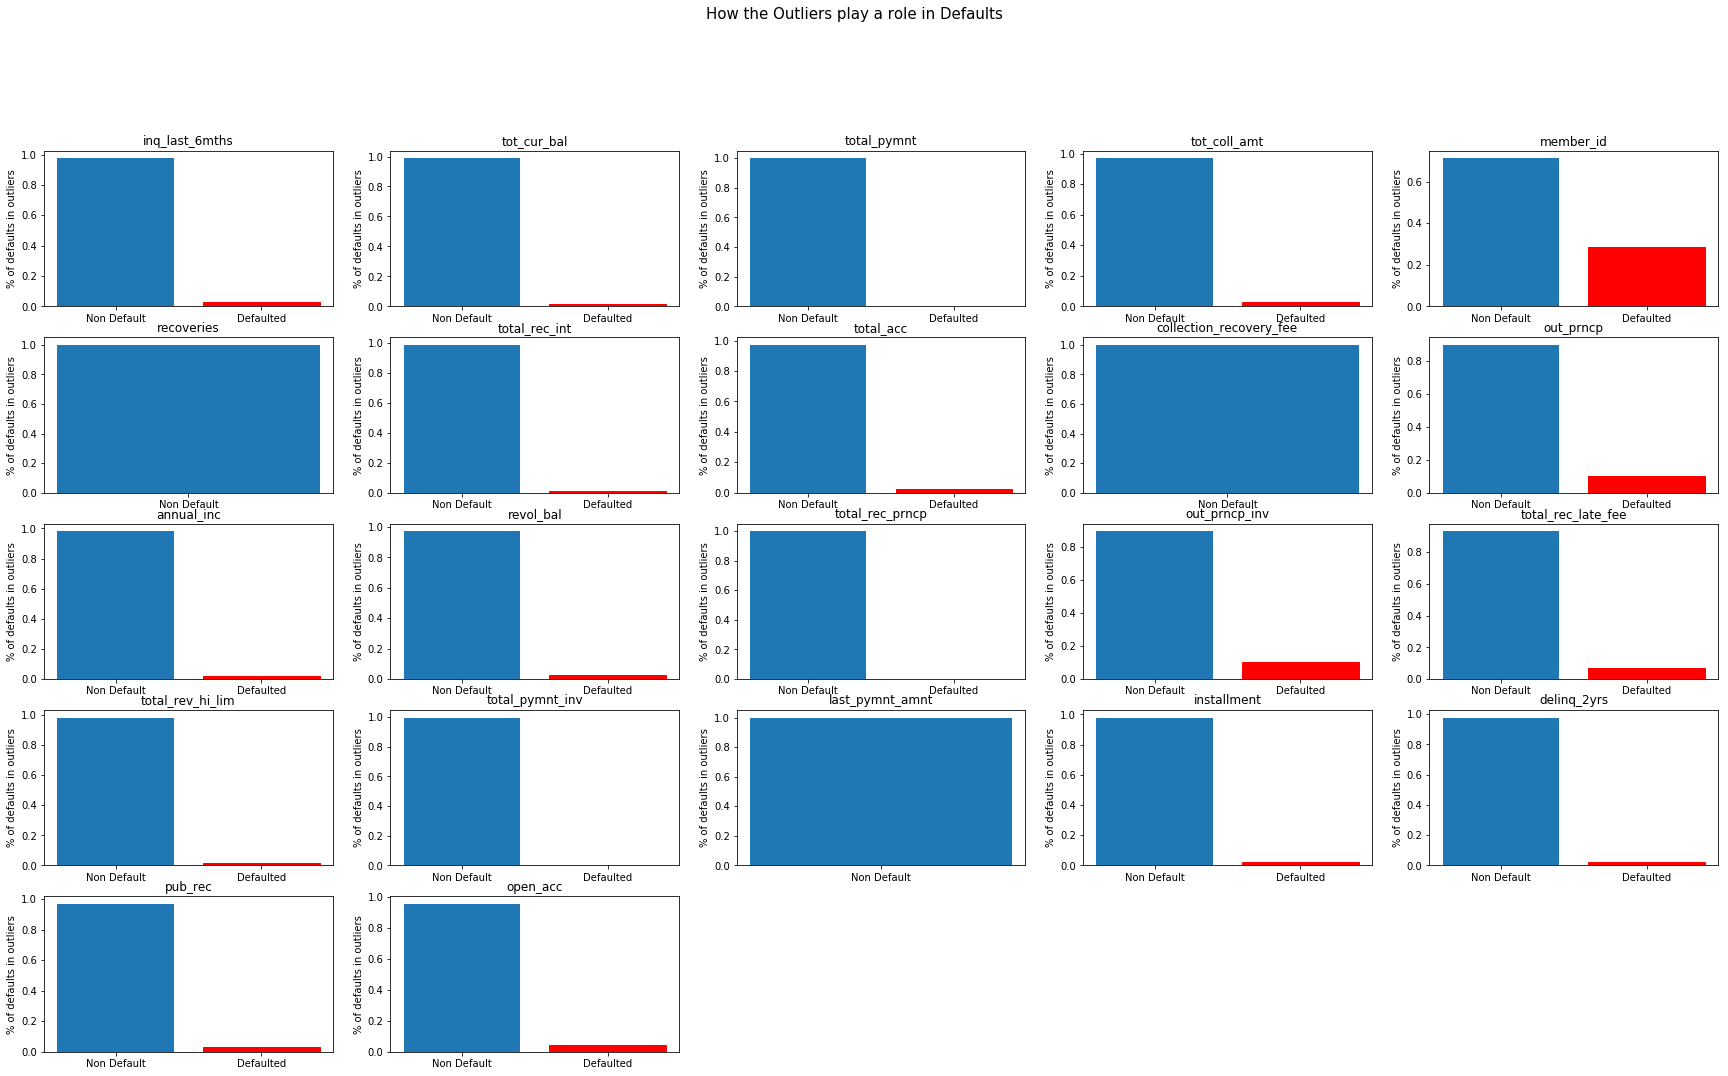

In [74]:
## Using the IQR method to filter and remove outliers from Item Visibility
outlier_plot_effects = list()

for i in numerical_data: 
    seventy_5th_q = df[i].quantile(.75)
    twenty_5th_q  = df[i].quantile(.25) 
    IQR = seventy_5th_q- twenty_5th_q
    Lower_bound = twenty_5th_q - (IQR * 1.5)
    Upper_bound = seventy_5th_q + (IQR * 1.5)
    #print(Upper_bound)
    outlier = list()
    outlier_position = list()
    for p, k in enumerate(df[i]): 
        #print(k)
        if  k > Upper_bound: 
            outlier.append(k)
            outlier_position.append(p)
        elif k < Lower_bound: 
            outlier.append(k)
            outlier_position.append(p)
        else: 
            pass
    print("COLUMN: {}  ---  percentage of outliers   =  {}%".format(i,round(len(outlier)/len(df) * 100)))
    
    outlier_pct = round(len(outlier)/len(df) * 100)
    temp_df = df.iloc[outlier_position, :].copy()
    plot_df= temp_df.groupby("Defaulted")[i].count() / len(temp_df)
    
    
    if  outlier_pct > 1:
        outlier_plot_effects.append(plot_df)
    else: 
        #print("{} has no records of Fraudulent Activity".format(i))
        pass

    
Total_Positions = len(outlier_plot_effects)

Total_Columns = Total_Positions // 4  

Rows = Total_Positions // Total_Columns
Rows += Total_Positions % Total_Columns

Position = range(1, Total_Positions + 1)

#plt.rcParams['figure.constrained_layout.use'] = True

fig = plt.figure(figsize=(30, 20))
fig.suptitle("How the Outliers play a role in Defaults", fontsize = 15)


for i, k in enumerate(outlier_plot_effects): 
    x = k.index
    y = k.values
    ax = fig.add_subplot(Rows, Total_Columns, Position[i])
    barlist = ax.bar(k.index, k.values)
    ax.set_ylabel("% of defaults in outliers")
    try: 
        barlist[1].set_color('r')
        ax.set_xticks(range(2))
        ax.set_xticklabels(['Non Default','Defaulted'])
    except: 
        ax.set_xticks(range(1))
        ax.set_xticklabels(['Non Default'])
    #ax.boxplot(df[k])
    ax.set_title("{}".format(k.name))


### Splitting the Dataset: 

In [ ]:
## Splitting the data into Training and Testing Data: 
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1:].values.reshape(-1,)

standard_scaler = StandardScaler()

X = standard_scaler.fit_transform(X)

os.chdir("ScaledVariables_pickles/")

with open("Standard_Scaler.pickle", 'wb') as f: 
    pickle.dump(standard_scaler, f)
    
os.chdir("..")

# Balance The Dataset

Trying to get a better representation of the Defaulted target data. 

In [ ]:
before_resamp_df = pd.concat([pd.DataFrame(X, columns = df.columns[:-1]) ,pd.DataFrame(Y, columns = df.columns[-1: ])], axis =1 )

percent_default = round(before_resamp_df.groupby('Defaulted')['loan_amnt'].count()/len(before_resamp_df)*100, 2)
_ = percent_default.plot.bar()
_ = plt.title("Percent of loans defaulted after oversampling the minority class")
_ = plt.ylabel("Class balances(%)")
_ = plt.xlabel("Default Status")

In [ ]:
#### Resampling the minority Class. 
from imblearn.over_sampling import RandomOverSampler

X_resamp, y_resamp = RandomOverSampler(random_state = 0, sampling_strategy = 0.15).fit_resample(X, Y)

resamp_df = pd.concat([pd.DataFrame(X_resamp, columns = df.columns[:-1]) ,pd.DataFrame(y_resamp, columns = df.columns[-1: ])], axis =1 )

percent_default = round(resamp_df.groupby('Defaulted')['loan_amnt'].count()/len(resamp_df)*100, 2)
_ = percent_default.plot.bar()
_ = plt.title("Percent of loans defaulted after oversampling the minority class")
_ = plt.ylabel("Class balances(%)")
_ = plt.xlabel("Default Status")

In [ ]:
## Resampled dataset

X_train_resamp, X_test_resamp, y_train_resamp, y_test_resamp = train_test_split(X_resamp, y_resamp, test_size = 0.2, random_state = 0)

Default_test = y_test_resamp == 1
print("Total Defaulted Cases in testing Data: {}".format(sum(y_test_resamp[Default_test])))
Default_train = y_train_resamp == 1
print("Total Defaulted Cases in training Data: {}".format(sum(y_train_resamp[Default_train])))

In [ ]:
## Non resampled
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20,  random_state = 0)

Default_test = y_test == 1
print("Total Defaulted Cases in testing Data: {}".format(sum(y_test[Default_test])))
Default_train = y_train == 1
print("Total Defaulted Cases in training Data: {}".format(sum(y_train[Default_train])))

#### This should give a better representation of the minority class 


# Building the Model. 
### Comparison of results from non resampled to resampled dataset. Seeing how XGboost handles the resampling of the data. 

Given the imbalanced data set that I have from above, ~2% representation of positive target feature. 
<br> I will approach this problem by two different methods. The first approach will be to implement random oversampling of the imbalanced class, and train some classifiers on the data with the recall metric in focus. 
<br> I will then attempt to leave the data as is, I have some concerns with overfitting the data utilizing random over sampling, and will attempt to classify based off of an ensemble method. My choice will be to classify with XGboost. 
<br> After all is said and done, I will choose the best model that performs well on recall. 

# Random Forest Algorithm

### Non resampled Dataset



In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_grid = {
    'n_estimators' : [250, 500, 750, 1001],
    'max_features' : [range(2,12, 2)],
    'criterion'    : ['gini', 'entropy'],
        
}



random_forest_classifier = RandomForestClassifier()





In [ ]:
random_forest_classifier.fit(X_train, y_train)
y_pred = random_forest_classifier.predict(X_test)

### Resampled Dataset

# Support Vector Machine

### Non Resampled

In [ ]:
from sklearn.svm import SVC

### Resampled: 

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
len(X_train)

### Given the potential for misrepresentation in random forest, maybe try a boosted model. 
Gradient Boosting and Extreme Gradient Boosting

I want to compare how one fares over another in imbalanced learning scenarios

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

